Consider a general problem representative of a stream where using the tools seen in class.

# Mining data streams

In this notebook, rather than presenting the different tools for analyzing a data stream, we discuss a practical use case that requires the use of such tools.

We will not suggest any specific library (e.g., implementation of the Bloom filter), so the student has to search and choose the ones that best suit the project requirements.  

## Caches, and cache hit ratio

Caches can be used at different levels and are a tool to decrease the traffic between client and server

We consider a Web cache, i.e., a server with a specific amount of memory $M$, that intercepts the user requests for Web pages (items) and:

- if the item is not in the cache, it retrieves it from the origin server (which keep ALL the items), replies to the user, and decides if caching such an item;
- if the item is already stored in the cache, it replies directly to the user (= save time and resources, since the server is closer to the user than the origin one)

<br>
<img src=https://appcheck-ng.com/wp-content/uploads/Web-Cache-Diagram.png width="300">
<br>



Since the memory is limited, the cache needs to decide which items should be stored (and what is stored will be deletd if it's not asked for in a long time). This can be formalized with a **cache mananagement policy**, that decides the item *admission* (usually there is no policy, every element is added to the cache) and *eviction* (policy to decide which element to remove when the cache is full, based iìon Least Recently Used).

The admission regulates the decision related to a requested item that is not in the cache. The eviction regulates which item should be removed in case there is no storage space left and a new item must be stored.

The choice of which policy should be adopted is driven by the effect on a performance index, the **hit ratio**:

$$
\mbox{Hit ratio} = \frac{\mbox{requests satisfied by the cache}}{\mbox{received requests}}
$$
It measures how well a cache works (should be 60%/80%).

A well-known cache management policy is **LRU** (Least Recently Used). This policy maintains the list of stored items sorted by their access time. In case of a request for an item already stored in the cache, there is a *hit* and the item is moved to the front/head of the sorted list. In case of a request for an item not stored in the cache, there is a *miss*, the item then is placed at the front of the sorted list, and the last item in the list is removed when I have to evict.

Note that, in case of item of different sizes, more than one items could be removed to make room for the new item -- conversely, a single item may free a lager space than necessary -> LRU is no longer optimal.

## A basic LRU cache implementation

Use a request trace: keep track of the item requested + at what time.

We assume that each item is associated to a kay-value pair, where the *key* is the item identifier and the *value* is the item itself. 
A cache server usually exposes two interfaces (also called API): ```get(key)``` and  ```set(key, value)```. The former is used to query the cache: if the item (identified by that key) is stored in the cache, it is returned, otherwise nothing is returned. the latter is used to store an item to the cache.

Let's create a class that simulate the behavior of a cache. We will use ```OrderedDict```, which is a special implementation of a dictionary in which the insertion order is maintained. In addition, we will use the parameter *value* when storing an item for storing the item size, rather than the item itself (this is a simulation of a cache, not a real cache).

In [1]:
from collections import OrderedDict
# Define a class
class LRUCache:

    def __init__(self, max_size = 100):
        if max_size <= 0:
            raise ValueError
        self.items = OrderedDict() # ordered dictionary
        # Inizialize the cache
        self.max_size = max_size
        self.curr_size = 0

    # CHECK if element is in the cache
    # If the element is in the cache = hit, I receive it (otherwise I receive nothing)
    def get(self, key):
        if key not in self.items:
            return None
        self.items.move_to_end(key) # update the position to the end
        return self.items[key] # return elemt itself

    # STORE the elemnt in the cache
    # Note that the parameter "value" is used to store the item size, not the actual item
    def set(self, key, value=1):
        if value <= 0:
            raise ValueError
        self.items[key] = value
        self.items.move_to_end(key) # move to the end
        self.curr_size += value
        evicted = []
        while self.curr_size > self.max_size: # if the size of elements stored is bigger than the cache, I have to evict
            rem_k, rem_v = self.items.popitem(last=False)
            evicted.append(rem_k)
            self.curr_size -= rem_v
        return evicted

## Item request trace 

I trace the identifier of the object and the size f it (I can remove the time!)  -> consider elements of same size

Portions of data streams can be recorded into a file so that they can be replayed for testing purpose (e.g., to check if a different caching management policy produces higher hit ratios). We will use one trace collected from a real-world Web cache. The format is very simple: each line contains the item that has been requested, i.e., its key and the size of the item returned. See for example:

```
0 310
1 2324
2 74
3 19076
4 31061
5 817
```

The trace contains more than **11 Millions** requests.

We will read this trace, store the items into a LRU cache, and compute the hit ratio over time (at regular intervals). We start with a simple case in which we do not consider the item size.

*Note that we read directly the gzipped file, without the need to unzip it.*

In [2]:
import gzip

# input parameters
input_file = "6-ak1vot3_255t60_trace.txt.gz"
cache_max_size = 10000
max_num_req = 1000000
delta_req = 10000 # register the hit ratio at regular intervals

# other variables
hits = 0.0
hit_ratio_vs_time = []
cache = LRUCache(cache_max_size)

# open the trace and read it line by line
with gzip.open(input_file, 'r') as f_trace:
    for num_req, line in enumerate(f_trace):
        # stop reading the file if you reached the max num of reqs
        if max_num_req > 0 and num_req > max_num_req:
            break
        splitted_line = line.split()
        item_id = int(splitted_line[0])
        # for the moment, we do not consider the item size
        # item_size = int(splitted_line[1])
        item_size = 1 # set the size to 1 to simplify things
        
        # check if the item is in the cache
        val = cache.get(item_id)
        if val is None: # if it's not in the cache, I put it in it
            evicted = cache.set(item_id, item_size)
        else: # if it's in the cache, I record that it is a hit
            hits += 1.0
        
        # for the graph
        if num_req > 0 and num_req%delta_req == 0:
            hit_ratio_vs_time.append(hits/num_req)

We can now plot the hit ratio over time

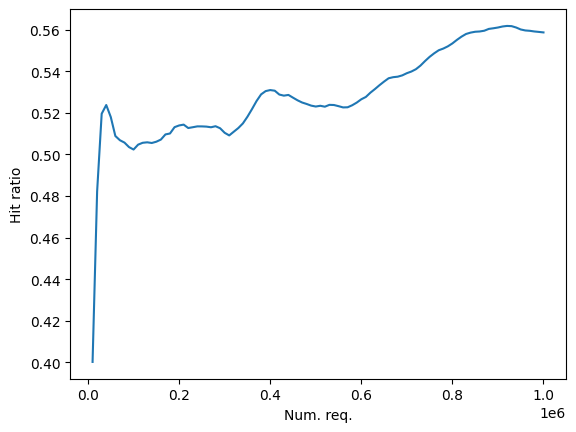

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(delta_req, num_req, delta_req), hit_ratio_vs_time)
plt.xlabel('Num. req.')
plt.ylabel('Hit ratio')
plt.show()

Start with low hit ration, then get to 50% and keep increaing.

### Question  Q1
<div class="alert alert-info">
Analyze the general characteristics of the trace, such as:
    
- Exact number of requests;
- Number of distinct items;
- Average item size, and item size empirical distribution;
- Popularity empirical distribution (how many times each item is requested, sorted by most to least popular);

</div>

In [4]:
# your answer

### Question  Q2
<div class="alert alert-info">
Change the cache size and observe its impact on the hit ratio. What happens when the cache is extremely small (e.g., 100)? And when it is extremely large? 
    
<br>

Note: A graph that contains the value of the cumulative hit ratio for different cache sizes is called "Hit Ratio Curve (HRC)", and its complement to 1 is called "Miss Ratio Curve (MRC)". The MRC is  a common tool used to characterize a cache management policy. 
</div>

In [5]:
# your answer

### Question  Q3
<div class="alert alert-info">
Introduce the item size (and adjust the cache size accondingly) and observe the impact of the cache size on the hit ratio.
</div>

In [6]:
# your answer

## Open problem P1

When we consider the hit ratio, we keep track of the cumulative number of hits over the comulative number of requests. This *averaging effect* may hide some temporal fluctuation.

<div class="alert alert-info">
How can we measure the instantaneous hit ratio?
</div>

There could be different solutions to this problem, but we do not know which one works best, so we should compare all of them.

The options are:

- RESET: considering an interval of $R$ requests, count the number of hits in that interval (each interval is independent);
- SLIDING: consider a sliding window of the last $R$ requests and update the hit ratio accordingly;
- DECAYING: use an exponentially decaying window instead of a sliding window.

The three policies has different parameters, so one should also study the impact of such parameters.

In [7]:
# your answer

## Open problem P2

Looking closely at the statistics of the trace, it is possible to notice that many items are requested just once. This phenomenon is not specific to this trace, but it can be found in many real-world traces, and it is usually referred to as *one-hit wonders*.

One-hit wonders may be problematic, since they waste space: in fact, they enter in the LRU cache (causing the eviction of other items), but they do not generate any hit. 

<div class="alert alert-info">
How can we efficiently estimate the number (or the percentage) of one-hit wonders in a stream?
</div>

The solution of the above problem implies that we estimate how many distinct items the stream contains, and among them which items have more than one request. This may require the use of multiple tools.

<div class="alert alert-info">
Can we design a policy that exclude one-hit wonders from the cache?
</div>

Unfortunately it is not possible to known in advance which requests will be one-hit wonders, so any policy will have an impact on all the items. This means that the gain obtained from excluding the one-hit wonders could be counterbalanced by the loss due to the regular items. But we can know it only if we try!

The task will be to design a new policy, which we will call 2-STEPS, that will admit a new item only if it is the second time that is has been requested.

```python
class 2-STEPS:

    def __init__(self, max_size):
        # same as LRU, with some additional data structure

    def get(self, key):
        # same as LRU

    def set(self, key, value):
        # this must be change to reflect the admission policy;
        # eviction is the same as LRU

```

*Hint:* We need to keep track in an **efficient** way the item seen so far; but we should also avoid the data structure saturation...

In [8]:
# your answer